# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [334]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [335]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [336]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [337]:
# https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py

def apk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
  # if num of predicted items is already more than top-k relevant items
  # then we just take k first values
  if len(predicted) > k:
      predicted = predicted[:k]

  score = 0.0
  num_relevant = 0.0

  for i, p in enumerate(predicted):
      if p in relevant and p not in predicted[:i]:
          num_relevant += 1.0
          score += num_relevant / (i + 1.0)

  if not relevant:
      return 0.0

  return score / min(len(relevant), k)

def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    return np.mean([apk(a, p, k) for a, p in zip(relevant, predicted)])

In [338]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

При выполнении задания 5 я столкнулась с проблемой, что вычисления производятся 999 лет, они буквально не заканчиваются, поэтому я беру лишь часть датасета.

In [339]:
max_userId = 30

ratings_batch = []

for userId, user_data in tqdm(ratings.groupby('userId')):
  if userId == max_userId:
    break
  ratings_batch += [user_data]

ratings_batch = pd.concat(ratings_batch).reset_index(drop=True)
ratings_batch.head()

  0%|          | 0/241 [00:00<?, ?it/s]

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [340]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [341]:
train_ratings, test_ratings = train_test_split(ratings_batch)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [293]:
train_ratings.tail()

,userId,trackId
16928,29,50682
16929,29,50761
16930,29,50780
16931,29,50781
16932,29,50782


In [294]:
train_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16933 entries, 0 to 16932
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   userId   16933 non-null  int64
 1   trackId  16933 non-null  int64
dtypes: int64(2)
memory usage: 264.7 KB


Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [343]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [296]:
tracks_info.tail()

,id,name,artists
636,2739,Восход,['Combat Cars']
637,2740,24,['Luxor']
638,2741,Аноним,['#2Маши']
639,2742,Ты должна рядом быть,"['Мари Краймбрери', 'MOT']"
640,2743,I'm Into It,"['Paul Oakenfold', 'ZHU', 'Velvet Cash']"


In [344]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [345]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [299]:
train_ratings.head()

,userId,trackId
0,0,9
1,0,34
2,0,71
3,0,72
4,0,124


In [300]:
test_ratings.head()

,userId,trackId
0,0,11997
1,0,12047
2,0,13279
3,0,13462
4,0,13465


Соберем все релевантные треки для каждого пользователя в список.

In [346]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [347]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []

        for uid in range(self.n_users):
          test_preds.append(self.recommend(uid))

        test_preds = self.remove_train_items(test_preds, k)
        test_users = self.ratings['userId'].unique()

        return test_preds[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [328]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    common_mask = (ratings > 0) & (user_vector > 0)

    numerator = np.sum(ratings * user_vector * common_mask, axis=1)

    denominator = (np.sqrt(np.sum((ratings)**2, axis=1)) *
                      np.sqrt(np.sum((user_vector)**2)))

    return numerator / denominator


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    numerator = np.sum((ratings > 0) & (user_vector > 0), axis=1)
    denominator = np.sum((ratings > 0) | (user_vector > 0), axis=1)
    denominator = np.where(denominator == 0, 1e-10, denominator)

    return numerator / denominator

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [329]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        relevant = np.zeros(self.n_items)

        user_vector = self.R[uid]

        similarities = self.similarity(user_vector)
        similar_users = [u for u in range(self.n_users) if u != uid and similarities[u] > self.alpha]

        for item in range(self.n_items):
          denominator = np.sum([np.abs(similarities[sim_u]) for sim_u in similar_users])
          if denominator:
            numerator = np.sum([similarities[sim_u] * self.R[sim_u, item] for sim_u in similar_users])
            relevant[item] = numerator / denominator

        return np.argsort(relevant)[::-1]

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

При max_userId == 20

In [286]:
len(test_relevant)

16

In [287]:
ks = list(range(1, 20))
pear_mapk, jacc_mapk, rand_mapk = [], [], []

pear_model = User2User(train_ratings, pearson)
jacc_model = User2User(train_ratings, jaccard)
base_model = BaseModel(train_ratings)

for k in ks:
  pear_recs = pear_model.get_test_recommendations(k)
  pear_mapk.append(mapk(test_relevant, pear_recs, k))

  jacc_recs = jacc_model.get_test_recommendations(k)
  jacc_mapk.append(mapk(test_relevant, jacc_recs, k))

  # generating k random items' indices for every user
  rand_recs = [np.random.choice(np.arange(base_model.n_items), k, replace=False) for _ in range(base_model.n_users)]
  rand_mapk.append(mapk(test_relevant, rand_recs, k))

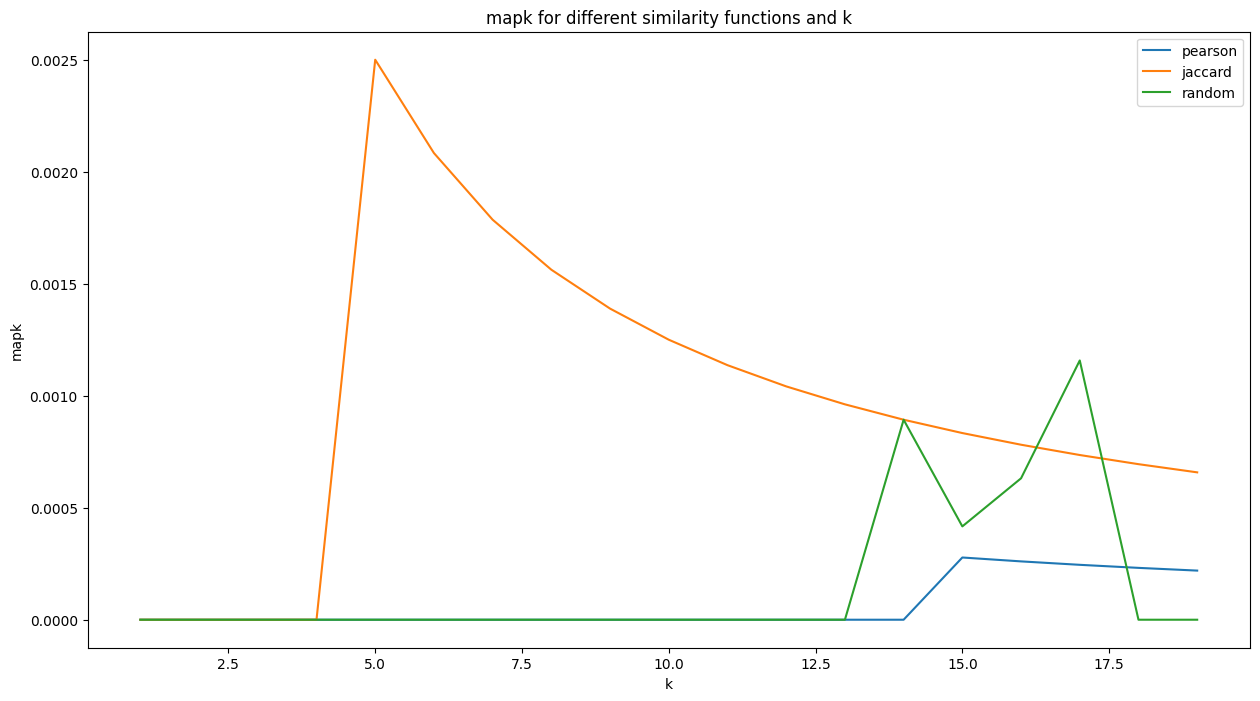

In [288]:
plt.figure(figsize=(15, 8))

plt.plot(ks, pear_mapk, label='pearson')
plt.plot(ks, jacc_mapk, label='jaccard')
plt.plot(ks, rand_mapk, label='random')

plt.title('mapk for different similarity functions and k')
plt.xlabel('k')
plt.ylabel('mapk')
plt.legend()

plt.show()

При max_userId == 40.

In [223]:
ks = list(range(1, 20))
pear_mapk, jacc_mapk, rand_mapk = [], [], []

pear_model = User2User(train_ratings, pearson)
jacc_model = User2User(train_ratings, jaccard)
base_model = BaseModel(train_ratings)

for k in ks:
  pear_recs = pear_model.get_test_recommendations(k)
  pear_mapk.append(mapk(test_relevant, pear_recs, k))

  jacc_recs = jacc_model.get_test_recommendations(k)
  jacc_mapk.append(mapk(test_relevant, jacc_recs, k))

  # generating k random items' indices for every user
  rand_recs = [np.random.choice(np.arange(base_model.n_items), k, replace=False) for _ in range(base_model.n_users)]
  rand_mapk.append(mapk(test_relevant, rand_recs, k))

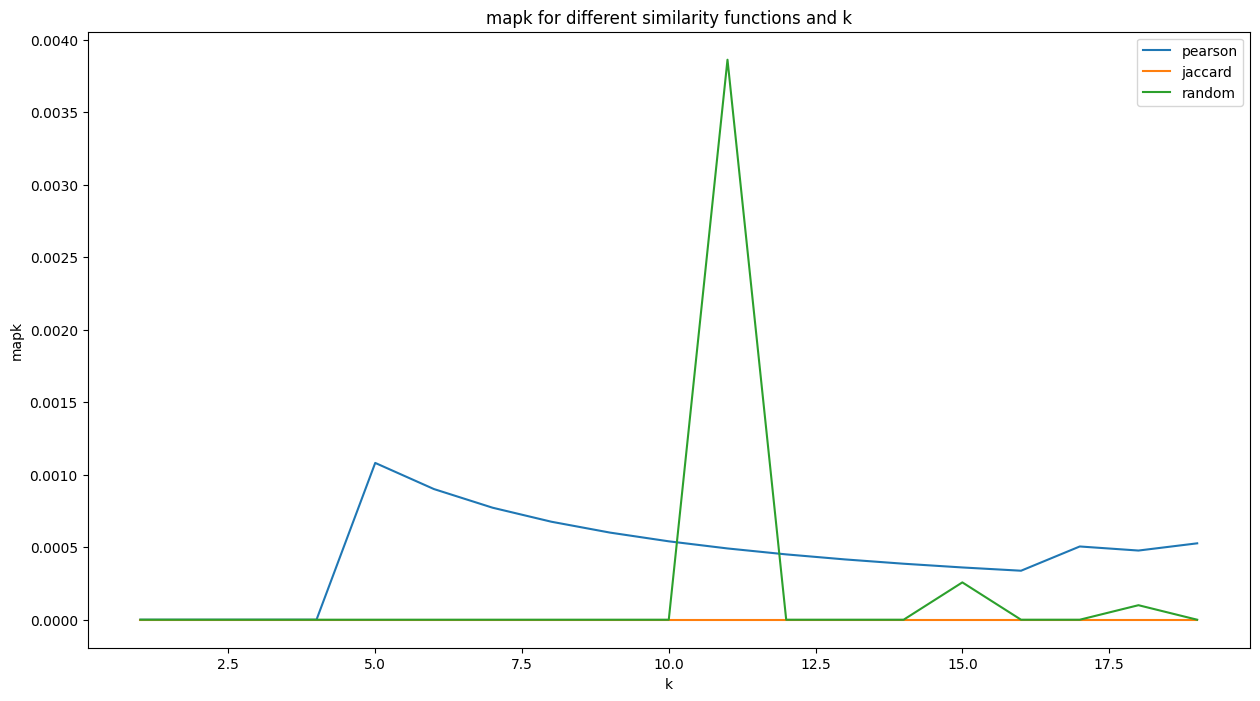

In [224]:
plt.figure(figsize=(15, 8))

plt.plot(ks, pear_mapk, label='pearson')
plt.plot(ks, jacc_mapk, label='jaccard')
plt.plot(ks, rand_mapk, label='random')

plt.title('mapk for different similarity functions and k')
plt.xlabel('k')
plt.ylabel('mapk')
plt.legend()

plt.show()

При max_userId == 30

In [307]:
len(test_relevant)

28

In [305]:
ks = list(range(1, 20))
pear_mapk, jacc_mapk, rand_mapk = [], [], []

pear_model = User2User(train_ratings, pearson)
jacc_model = User2User(train_ratings, jaccard)
base_model = BaseModel(train_ratings)

for k in ks:
  pear_recs = pear_model.get_test_recommendations(k)
  pear_mapk.append(mapk(test_relevant, pear_recs, k))

  jacc_recs = jacc_model.get_test_recommendations(k)
  jacc_mapk.append(mapk(test_relevant, jacc_recs, k))

  # generating k random items' indices for every user
  rand_recs = [np.random.choice(np.arange(base_model.n_items), k, replace=False) for _ in range(base_model.n_users)]
  rand_mapk.append(mapk(test_relevant, rand_recs, k))

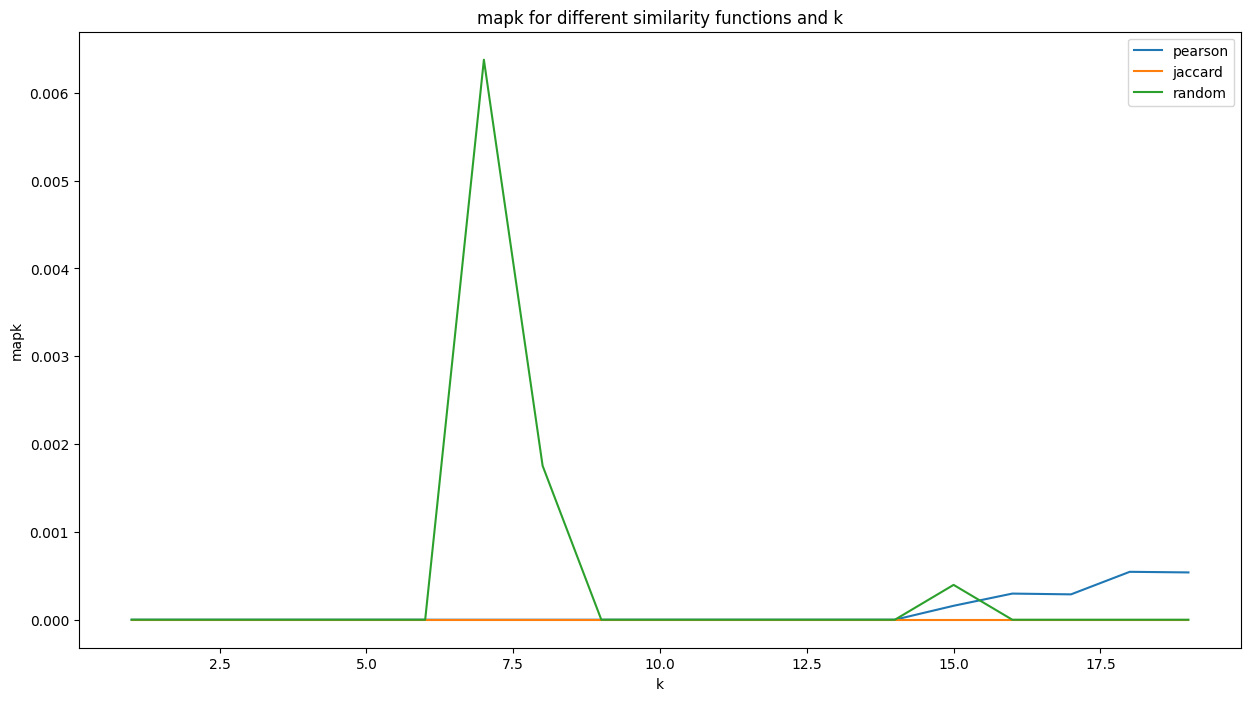

In [306]:
plt.figure(figsize=(15, 8))

plt.plot(ks, pear_mapk, label='pearson')
plt.plot(ks, jacc_mapk, label='jaccard')
plt.plot(ks, rand_mapk, label='random')

plt.title('mapk for different similarity functions and k')
plt.xlabel('k')
plt.ylabel('mapk')
plt.legend()

plt.show()

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [353]:
from scipy import sparse


class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []

        for user in range(self.n_users):
          user_recommendation = self.recommend(user) # get a recommendation
          test_preds.append(user_recommendation) # append this recommendation

        # get rid of already listened tracks
        test_preds = self.remove_train_items(test_preds, k)

        test_users = np.unique(self.ratings['userId']) # get unique users

        return test_preds[test_users] # return recommendations for the unique test users


class User2UserSparse(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02
        # self.R = sparse.csr_matrix(self.R)

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        relevant = np.zeros(self.n_items)

        user_vector = self.R[uid]

        similarities = self.similarity(user_vector)
        similar_users = [u for u in range(self.n_users) if u != uid and similarities[u] > self.alpha]

        for item in range(self.n_items):
          denominator = np.sum([np.abs(similarities[sim_u]) for sim_u in similar_users])
          if denominator:
            numerator = np.sum([similarities[sim_u] * self.R[sim_u, item] for sim_u in similar_users])
            relevant[item] = numerator / denominator

        return np.argsort(relevant)[::-1]

User2UserSparse(train_ratings, pearson).get_test_recommendations(15)

array([[ 8879,  9286,  7296,    91,  2743,  8230,   320,  6481,    59,
         1240,  1415,  2867,   767,    35,  9795],
       [ 2346,  6737,  8004,  1586,  8461, 10451,  6856,  6374,  3789,
         1440,  2857,  6225,  5498,   286,  4359],
       [ 2346,   131,   273,  1226,  6737,  8461,  3789,   286,  1908,
         6856,  1569,   244,  9850,   134,   135],
       [ 8806,  3324,  8392,  7254, 13675,  1419, 12464,  1226,  1906,
         5780, 13177,  9507,  9237, 10983,  1162],
       [ 6287,  1702,  7047,  2108,   132,  3819,  1966,  2939,  3739,
          850,  3352,  1159,   529,  1376,  4797],
       [ 1440,  1586,    72,   441,  1226,  6737,  8461,  9850,  3789,
         2346,  2758,  1598,  2766,  1433,  1702],
       [  600,  1117,   486, 10731,  1417,   240,  6047,  9850,   260,
          265,  4534,  1288,   345,  1242,  6448],
       [ 1376,  6287,  3201,   529,  3819,  5973,  4325,  8738,  2108,
         1137,  1702,   134,  1226,   132,  7553],
       [14388,  4720,  4

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [330]:
model = User2User(train_ratings, pearson)

In [331]:
user_id = np.random.randint(0, model.n_users)

In [332]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
933,Sonne,['Rammstein']
1243,The Way I Are,"['Timbaland', 'Keri Hilson', 'D.O.E.']"
2537,The Only,['Static-X']
3467,Love Don't Let Me Go,['David Guetta']
4032,Bring Me To Life,['Evanescence']
5676,I Like It,"['Enrique Iglesias', 'Pitbull']"
5715,Dynamite,['Taio Cruz']
5930,For An Angel,['Paul Van Dyk']
5948,Кто ты?,['Градусы']
6063,Whataya Want from Me,['Adam Lambert']


In [354]:
# never happened because of the dataset size

preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

KeyboardInterrupt: 

In [ ]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM**:

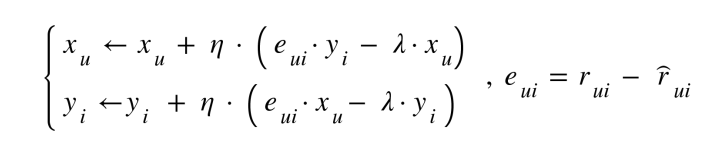

**ALS:**

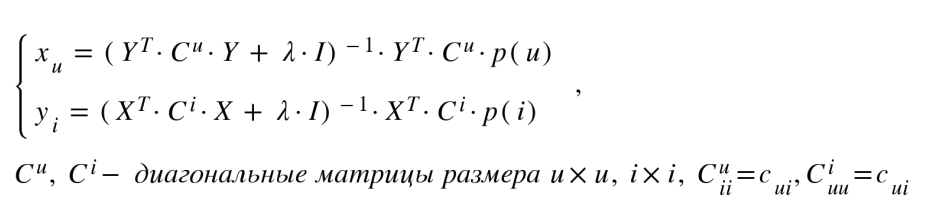

**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [362]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                for u, i in self.ratings:
                  pred = self.P.dot(self.Q.T)
                  err = ...

                  self.P[u, :] += self.lr * (err * self.Q[i, :] - self.lamb * self.P[u, :])
                  self.Q[i, :] += self.lr * (err * self.P[u, :] - self.lamb * self.Q[i, :])


            elif self.mode == 'als':
                for u in range(self.n_users):
                  # update value of P matrix
                  user_rating = self.ratings[u, :].toarray().flatten()
                  filled_ids = user_rating.nonzero()[0] # zero dim
                  self.P[u, :] = np.linalg.solve(
                      self.Q.T * self.Q + np.eye(self.dim) * self.lamb * len(filled_ids),
                      self.Q[filled_ids, :].T @ user_rating[filled_ids]
                      )

                for i in range(self.n_items):
                  # update value of Q matrix
                  item_rating = self.ratings[:, i].toarray().flatten()
                  filled_ids = item_rating.nonzero()[0]
                  self.Q[i, :] = np.linalg.solve(
                      self.P.T @ self.P + np.eye(self.dim) * self.lamb * len(filled_ids),
                      self.P[filled_ids, :].T @  item_rating[filled_ids]
                      )


    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks